### seoul_pm10 (LSTM)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [58]:
# 1. # 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [59]:
# 2. 데이터 로드
df_concat = pd.read_csv('dataset/seoul_pm10.csv', encoding="CP949") # 한글 깨짐 방지(인코딩)
df_concat['date'] = pd.to_datetime(df_concat['date']) # 날짜 변환
df_concat.head() # 데이터 상위 5개 출력력


,date,area,pm10,pm2.5
0,2022-12-31 23:00:00,강남구,57.00,44.00
1,2022-12-31 23:00:00,강동구,68.00,55.00
2,2022-12-31 23:00:00,강북구,59.00,42.00
3,2022-12-31 23:00:00,강서구,62.00,40.00
4,2022-12-31 23:00:00,관악구,57.00,38.00


In [60]:
# 강남구 데이터 필터링
gangnam_df = df_concat[df_concat['area'] == '강남구'].sort_values(by='date')

In [61]:
# 3. 데이터 전처리
# 결측치 확인
print("pm10 데이터 결측치 확인:")
print(df_concat.isnull().sum())
print("\npm10 데이터 결측치 확인:")
print(df_concat.isnull().sum())

# 결측치 제거
gangnam_df = gangnam_df.dropna()

pm10 데이터 결측치 확인:
date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64

pm10 데이터 결측치 확인:
date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64


In [62]:
# 4. 원핫 인코딩 (지역 컬럼)
ohe = OneHotEncoder(sparse_output=False)
area_encoded = ohe.fit_transform(df_concat[['area']])
area_encoded_df = pd.DataFrame(area_encoded, columns=ohe.get_feature_names_out(['area']))
df = pd.concat([df_concat, area_encoded_df], axis=1).drop(columns=['area'])

In [63]:
# 5. 정규화
scaler = MinMaxScaler()
gangnam_df['pm10'] = scaler.fit_transform(gangnam_df[['pm10']])

In [64]:
# 6. LSTM 모델에 적합한 시퀀스스 데이터셋 함수 생성
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)
# ✅ 이 함수는 PM10 농도 데이터를 LSTM 모델이 학습할 수 있도록 변환하는 역할을 합니다.
# ✅ 과거 seq_length개의 데이터를 보고, 다음 값을 예측하도록 만듭니다.
# ✅ 반환되는 X는 학습 데이터, y는 정답(실제 PM10 값)입니다.

In [65]:
# 7. 시퀀스 데이터 생성
seq_length = 24
X, y = create_sequences(gangnam_df['pm10'].values, seq_length)

# 8. 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [66]:
# 9. LSTM 모델 생성
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# LSTM 모델을 컴파일하는 부분입니다. - Adam : Adaptive Moment Estimation
# 모델이 학습할 때 사용할 **최적화 알고리즘(optimizer)**과 **손실 함수(loss function)**를 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # mse : 값이 작을수록 모델이 실제값과 더 가까운 예측을 하고 있다는 의미

c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 10. 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.5262e-04 - val_loss: 0.0011
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.6110e-04 - val_loss: 7.4878e-04
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.1344e-04 - val_loss: 5.4730e-04
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.7709e-04 - val_loss: 4.2709e-04
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4818e-04 - val_loss: 4.0882e-04
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.5044e-04 - val_loss: 3.9844e-04
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2981e-04 - val_loss: 3.6251e-04
Epoch 9/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3333e-04 - val_loss: 4.7365e-04
Epoch 10/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4360e-04 - val_loss: 3.5772e-04
Epoch 11/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1712e-04

In [ ]:
# 11. 예측 수행
y_pred = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# 12. 역정규화
y_test_inv =  scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

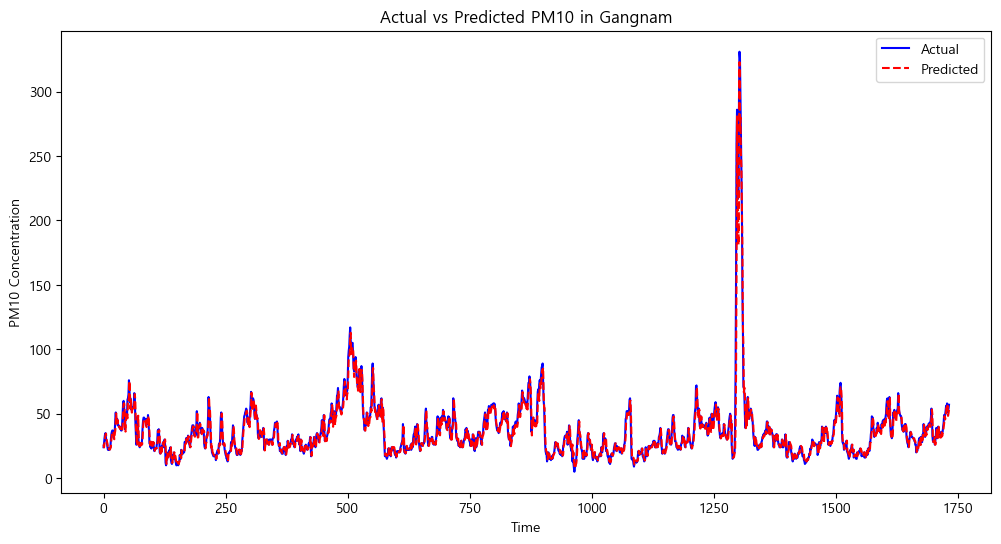

In [ ]:
# 13. 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('PM10 Concentration')
plt.title('Actual vs Predicted PM10 in Gangnam')
plt.legend()
plt.show()